# About 

This notebook is intended to be a POC for Experiment 4.2 in the Skantze 2017 paper. 

## Setup 

In [1]:
 # Download libraries for environment. 

import sys 
import os 

# Env. vars to check if the notebook is running on colab, kaggle etc. 
IS_COLAB = "google.colab" in sys.modules 
IS_KAGGLE = "kaggle_secrets" in sys.modules 
IS_LOCAL = not (IS_COLAB or IS_KAGGLE)

if IS_COLAB:
    # Install the packages 
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers
    %pip install -q -U datasets
    print("You can safely ignore the package incompatibility errors.")
    # Mount the drive 
    from google.colab import drive 
    drive.mount("/drive")

In [2]:

import os
import pandas as pd
import numpy as np
from copy import deepcopy 

import random 
import shutil 
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Pytorch imports 
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader

# Others 
import glob 

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)




In [3]:
# --  Set environment global vars. 

# Shared env. vars. 
GLOBAL_SEED = 42 
IS_CUDA_ENV = torch.cuda.is_available()
GLOBAL_DEVICE = torch.device('cuda') if IS_CUDA_ENV else torch.device('cpu')
SET_SEED = True # If true, sets the global seeds for this notebook. 
LIMITED_RESOURCES = not IS_CUDA_ENV

if LIMITED_RESOURCES:
    SMALL_DATASET_SIZE = 20

if IS_COLAB:
    LIMITED_RESOURCES = False 
   

In [4]:
# Configuring env. 
if SET_SEED:
    # to make this notebook's output stable across runs
    np.random.seed(GLOBAL_SEED) 
    torch.manual_seed(GLOBAL_SEED)

In [5]:
# Project Paths
NOTEBOOK_NAME = "skantze2017_exp_4_2_poc"
PROJECT_ROOT_DIR = "/Users/muhammadumair/Documents/Repositories/mumair01-repos/TRP-Modeling/skantze_2017_continuous" 
# --- Input data dirs. 

# --- Result dirs. 
# NOTE: The model dir will have to change depending on where the models are stored. 
PROCESSED_DATA_DIR =  os.path.join(PROJECT_ROOT_DIR,"data","processed",NOTEBOOK_NAME)
REPORTS_DIR = os.path.join(PROJECT_ROOT_DIR,"reports",NOTEBOOK_NAME)
SAVE_MODELS_DIR = os.path.join(PROJECT_ROOT_DIR,"models",NOTEBOOK_NAME)

# Paths to the specific feature sets 
FULL_PROCESSED_FEATURE_DIR = os.path.join(PROJECT_ROOT_DIR,"data", "processed", "maptask","full")
PROSODY_PROCESSED_FEATURE_DIR = os.path.join(PROJECT_ROOT_DIR,"data", "processed", "maptask","prosody")
FULL_PROCESSED_FEATURE_DIR

os.makedirs(PROCESSED_DATA_DIR,exist_ok=True)
os.makedirs(REPORTS_DIR,exist_ok=True)
os.makedirs(SAVE_MODELS_DIR,exist_ok=True)


In [6]:
RAW_DATA_DIR = os.path.join(PROJECT_ROOT_DIR,"data", "raw", "maptask")
MAPTASK_DIR = os.path.join(RAW_DATA_DIR,"maptaskv2-1")
# Paths within the maptask corpus 
STEREO_AUDIO_PATH = os.path.join(MAPTASK_DIR,"Data/signals/dialogues")
MONO_AUDIO_PATH = os.path.join(MAPTASK_DIR,"Data/signals/mono_signals")
# NOTE: The timed units are also used for Voice Activity annotations. 
TIMED_UNIT_PATHS = os.path.join(MAPTASK_DIR,"Data/timed-units") 
POS_PATH = os.path.join(MAPTASK_DIR,"Data/pos")


In [7]:
def save_fig(path, fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Required Code 

**NOTE** In this section, we are copying some required code from notebooks 1.0-* to 3.0-*.

Ay bugs in this code **should be fixed in the appropriate notebooks**. 

### MapTask Dataset Preprocessing

In [8]:
def get_maptask_participant(csv_path):
    filename, ext = os.path.splitext(os.path.basename(csv_path))
    filename_split = filename.split(".")
    participant = filename_split[1]
    return participant

def get_maptask_dialogue(csv_path):
    filename, ext = os.path.splitext(os.path.basename(csv_path))
    filename_split = filename.split(".")
    dialogue = filename_split[0]
    return dialogue

def read_data(dir_path,dialogue_name, participant,ext):
    """
    Assumption is that the basename . is the dialogue name. 
    """
    results = []
    data_paths = [p for p in os.listdir(dir_path)]
    data_paths = [os.path.join(dir_path,p) for p in data_paths if os.path.splitext(p)[1][1:] == ext]
    for path in data_paths:
       if get_maptask_dialogue(path) == dialogue_name and \
                get_maptask_participant(path) == participant:
            results.append(path)
    return results 

def get_mono_audio(dialogue_name, participant):
    return read_data(MONO_AUDIO_PATH,dialogue_name, participant,"wav")[0]

def get_stereo_audio(dialogue_name):
    return read_data(STEREO_AUDIO_PATH,dialogue_name,"mix","wav")[0]

def get_timed_unit(dialogue_name, participant):
    return read_data(TIMED_UNIT_PATHS,dialogue_name, participant,"xml")[0]

def collect_dialogue_features(dialogue_names, features_dir):
    """
    Collect the dialogue f and g feature files.
    Assumes that features_dir contains both the f and g feature files. 
    """
    collected = {}
    for dialogue in dialogue_names:
        collected[dialogue] = {
            "f" : read_data(features_dir,dialogue,"f","csv")[0], 
            "g" : read_data(features_dir,dialogue,"g","csv")[0]}
    return collected 




In [9]:
def extract_voice_activity_labels(feature_df, N):
    # TODO: FIx the delimiter 
    feature_df = feature_df[["frameTime","voiceActivity"]]
    assert not feature_df.isnull().values.any()
    frame_times_ms = np.asarray(feature_df["frameTime"])
    voice_activity_annotations = np.asarray(feature_df["voiceActivity"])
    assert frame_times_ms.shape[0] == voice_activity_annotations.shape[0]
    labels = np.zeros((frame_times_ms.shape[0],N)) # target label shape: Num Frames x N
    for i in range(len(frame_times_ms)):
        # Pad the last labels with 0 if the conversation has ended 
        if i + N > len(frame_times_ms):
            concat = np.concatenate(
                [voice_activity_annotations[i:],
                 np.zeros(N - (len(frame_times_ms)-i))])
            labels[i] = concat
        else:
            labels[i] = voice_activity_annotations[i:i+N]
    labels_df = pd.DataFrame(labels) 
    labels_df.insert(0,"frameTime",frame_times_ms)
    assert not labels_df.isnull().values.any()
    return labels_df 


### MapTask Dataset Code 

In [10]:

class Skantze2017VAPredictionMapTaskDataset(Dataset):
    """
    Maptask dataset for voice activity annotation sequence prediction.  
    NOTE: Needs a large amount of memory to load this. 
    """

    def __init__(self, feature_paths_map, sequence_length_ms, 
            prediction_length_ms, target_participant, frame_step_size_ms):
        # Vars. 
        self.feature_paths_map = feature_paths_map 
        self.sequence_length_ms = sequence_length_ms 
        self.prediction_length_ms = prediction_length_ms 
        self.target_participant = target_participant 
        self.frame_step_size_ms = frame_step_size_ms 
        # Calculated 
        self.num_context_frames = int(sequence_length_ms / frame_step_size_ms)
        self.num_target_frames = int(prediction_length_ms / frame_step_size_ms)
        # Storage 
        self.xs = [] 
        self.ys = [] 
        for dialogue in list(self.feature_paths_map.keys()):
            self.__load_data(dialogue)
        assert len(self.xs) == len(self.ys)

    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        if idx > self.__len__():
            raise Exception 
        return self.xs[idx], self.ys[idx]

    def __load_data(self, dialogue):
        s0_feature_df, s1_feature_df = self.__load_dataframes(dialogue)
        # Extract the voice activity labels for s0 as the target labels
        s0_target_labels_df = extract_voice_activity_labels(
            s0_feature_df,self.num_target_frames)
        # Make sure none of the dfs have any nan values 
        assert not s0_feature_df.isnull().values.any() and \
            not s1_feature_df.isnull().values.any() and \
            not s0_target_labels_df.isnull().values.any()
        # Trim the dataframes to the same length 
        min_num_frames = np.min([len(s0_feature_df.index),len(s1_feature_df.index)])
        s0_feature_df = s0_feature_df[:min_num_frames]
        s1_feature_df = s1_feature_df[:min_num_frames]
        s0_target_labels_df = s0_target_labels_df[:min_num_frames]
        # Make sure they all have common frametimes
        assert s0_feature_df['frameTime'].equals(s1_feature_df['frameTime'])
        assert s0_feature_df['frameTime'].equals(s0_target_labels_df['frameTime'])
        s0_s1_df = pd.concat([s0_feature_df,s1_feature_df],axis=1)     
        assert not s0_s1_df.isnull().values.any()     
        # Determine the number of sequences for this dialogue 
        num_sequences = int(np.floor(len(s0_feature_df.index))/self.num_context_frames)
        for i in range(num_sequences):
            x = np.asarray(s0_s1_df.loc[:,s0_s1_df.columns != 'frameTime'][i * \
                self.num_context_frames : (i * self.num_context_frames) \
                    + self.num_context_frames])
            y = np.asarray(s0_target_labels_df.loc[:,s0_target_labels_df.columns\
                    != 'frameTime'][i * self.num_context_frames : \
                        (i * self.num_context_frames) + self.num_context_frames])[-1,:]
            self.xs.append(x)
            self.ys.append(y)

    def __load_dataframes(self, dialogue):
        if self.target_participant == "f":
            s0_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["f"], index_col=0,delimiter=",") 
            s1_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["g"],index_col=0,delimiter=",")
        else:
            s0_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["g"],index_col=0,delimiter=",") 
            s1_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["f"],index_col=0,delimiter=",")
        return s0_feature_df, s1_feature_df 



In [11]:
import random
from copy import deepcopy
from sklearn.model_selection import train_test_split 

In [12]:
def get_train_val_test_dialogues(dataset_paths, test_size=0.25, val_size=0.2, 
        seed=GLOBAL_SEED):
    dataset_paths = deepcopy(dataset_paths)
    dialogue_names = sorted(list(set([get_maptask_dialogue(p) for p in dataset_paths])))
    train_dialogues, test_dialogues = train_test_split(dialogue_names, 
        test_size=test_size,random_state=seed)
    train_dialogues, val_dialogues = train_test_split(train_dialogues, 
        test_size=val_size,random_state=seed)
    return train_dialogues, val_dialogues, test_dialogues 


### MapTask Dataclass and Method Definitions 

These are required to be in the same notebook to be loaded. 


NOTE: **DO NOT** modify these here, refer to 2.0-MU-Skantze-MapTask-Dataset-POC

In [13]:
# NOTE:Seed worker can be used to ensure reproducibility in DataLoader 
# across runs. 
def seed_worker(worker_id):
    worker_seed =GLOBAL_SEED
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def generate_dataloader(dataset, batch_size=32, shuffle=True, num_workers=0, 
        drop_last=True, pin_memory=True):
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        num_workers=num_workers, 
        drop_last=drop_last, # We always want to remove the last incomplete batch. 
        pin_memory=pin_memory, 
        worker_init_fn=seed_worker)

### Skantze 2017 Model

In [14]:
class Skantze2017LSTMPredictor(nn.Module):
    # TODO: The seed parameter is used to make sure that the layer initializations 
    # are the same across runs for model comparison - this should probably be 
    # either refactored or replaced.  
    def __init__(self, input_dim, hidden_dim, output_dim, layer_dim=1, seed=None):
        super().__init__()
        # Defining the vars. 
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim 
        self.output_dim = output_dim
        self.layer_dim = layer_dim
        # LSTM Layers
        if seed != None:
            torch.manual_seed(seed)
        self.lstm = nn.LSTM(input_dim, hidden_dim,layer_dim,batch_first=True) #  tanh activation is the default. 
        # Fully connected layer
        if seed != None:
            torch.manual_seed(seed)
        self.fc = nn.Linear(hidden_dim,output_dim,bias=True)
        if seed != None:
            torch.manual_seed(seed)
        self.fc_activation = nn.Sigmoid()

    def forward(self, x):
        # Initialize the hidden states for first input with zeroes. 
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize the cell state for the first input with zeroes. 
        c0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()

        # TODO: Still need to implement TBPTT in the model for the last 10 seconds, 
        # which is what was done in the Skantze paper. 

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x.float(),(h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :] # Because we need the final output. 
        return self.fc_activation(self.fc(out))


### General Training Utility Methods 

In [15]:
# Writing training loop for a single batch 

def train_step(model,optimizer, loss_fn, x, y):
    # Make sure X type is correct. 
    x = x.type(torch.FloatTensor)
    # NOTE: The input should not have any nans. 
    assert not torch.isnan(x).any()
    model.train()
    optimizer.zero_grad()
    y_hat = model(x)
    assert not torch.isnan(y_hat).any()
    assert not torch.isnan(y).any()
    loss = loss_fn(y,y_hat)
    assert not torch.isnan(y).any()
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(),1.0)
    optimizer.step()
    return loss

def validate_step(model, loss_fn, x,y):
    with torch.no_grad():
        model.eval()
        y_hat = model(x)
        loss = loss_fn(y,y_hat).item()
        return loss 

def next_batch(dataloader):
    # Loop over dataset 
    for x_batch ,y_batch in dataloader:
        yield x_batch, y_batch 

In [16]:
def train(model,optimizer, loss_fn,train_dataloader, val_dataloader, n_epochs,
        validate_n_epochs=1,save_n_epochs=None, save_fn = None,
        print_n_epochs=None):
    # Set the model to training 
    model.train()

    # Vars. to record results across training 
    training_losses = []
    validation_losses = [] 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0 
        samples = 0.0 

        # Run the training batch 
        for batch_x, batch_y in next_batch(train_dataloader):
            loss = train_step(model, optimizer,loss_fn,batch_x, batch_y)
            # -- Updates loss etc. 
            train_loss += loss.item() * batch_y.size(0) 
            # TODO: Not sure if this is the correct way to get accuracy. 
            samples += batch_y.size(0)
        training_losses.append(train_loss / samples)

        # Run the validation batch
        if epoch % validate_n_epochs == 0:
            batch_val_losses = []
            for batch_x, batch_y in next_batch(val_dataloader):
                loss = validate_step(model, loss_fn,batch_x,batch_y)
                batch_val_losses.append(loss) 
            validation_losses.append(np.mean(batch_val_losses))
        else:
            batch_val_losses = 0.0
        
        # Save the model if required. 
        if (save_n_epochs != None and epoch % save_n_epochs == 0 and save_fn != None) or \
                (save_fn != None and epoch == n_epochs):
            info = {
                "epoch" : epoch, 
                "loss" : train_loss/samples,
                "val_loss" : np.mean(batch_val_losses)}
            save_fn(model ,info)
        # Print if needed 
        if print_n_epochs != None and epoch % print_n_epochs == 0:
            print(f"[{epoch}/{n_epochs}] Training loss: {train_loss/samples:.4f}\t \
                Validation loss: {np.mean(batch_val_losses):.4f}")

    return training_losses, validation_losses



### Skantze2017 Model Specific Training Utility Methods 

In [17]:

# Methods to save and load this specific model. 

import h5py 

def save_for_inference(save_path):
    assert not os.path.isfile(save_path)
    return lambda model, info: (
        torch.save({
            "kwargs" : {
                "input_dim" : model.input_dim, 
                "hidden_dim" : model.hidden_dim,
                "output_dim" : model.output_dim,
                "layer_dim" : model.layer_dim}, 
            "info" : deepcopy(info),
            "model_state_dict" : model.state_dict()}, save_path))
    
def load_for_inference(save_file_path):
    assert os.path.isfile(save_file_path) 
    checkpoint = torch.load(save_file_path)
    model = Skantze2017LSTMPredictor(**checkpoint["kwargs"])
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, checkpoint['info']


def save_losses(save_dir, filename):
    assert os.path.isdir(save_dir)
    path = "{}/{}.h5".format(save_dir,filename)
    hf : h5py.File = h5py.File(path,'w')

    def h5_save_losses(grp_name, losses_dict):
        grp = hf.create_group(grp_name)
        for loss_name, losses in losses_dict.items():
            # loss_name = np.asarray(losses) 
            grp.create_dataset(loss_name, data=losses)
        
    return hf, path, h5_save_losses



### Skantze2017 Model Specific Testing Utility Methods 

In [18]:
def evaluate_skantze2017(model, test_dataloader):
    loss_fn = nn.L1Loss()
    losses = [] 
    va_losses = []
    with torch.no_grad():
        model.eval() 
        for x_batch, y_batch in next_batch(test_dataloader):
            x_batch = x_batch.view([1, -1, x_batch.size(-1)])
            y_hat = model(x_batch)
            loss = loss_fn(y_hat, y_batch)
            losses.append(loss) 
            nonzero_target_indices = np.nonzero(y_batch ==1)[:,1]
            if len(nonzero_target_indices) > 0:
                va_loss = loss_fn(
                    y_hat[:,nonzero_target_indices], y_batch[:,nonzero_target_indices])
                va_losses.append(va_loss)
        return losses , va_losses
            

### Prediction Dataset Code 

In [19]:
class Skantze2017PausesDataset(Dataset):

    HOLD_LABEL = 0 
    SHIFT_LABEL = 1 

    def __init__(self, feature_paths_map , sequence_length_ms, min_pause_length_ms, 
                max_future_silence_window_ms, s0_participant, frame_step_size_ms, 
                save_dir = None):
        # Params . 
        self.feature_paths_map = feature_paths_map 
        self.sequence_length_ms = sequence_length_ms 
        self.min_pause_length_ms = min_pause_length_ms
        self.max_future_silence_window_ms = max_future_silence_window_ms
        self.s0_participant = s0_participant
        self.frame_step_size_ms = frame_step_size_ms  
        self.save_dir = save_dir # If the save dir is provided, saves the dataset as it is built. 
        # Calculated 
        self.num_context_frames = int(sequence_length_ms / frame_step_size_ms)
        self.num_pause_frames = int(min_pause_length_ms / frame_step_size_ms)
        self.future_window_frames = int(max_future_silence_window_ms / frame_step_size_ms)
        # Data Storage vars. 
        self.xs = [] 
        self.ys = [] 
        self.num_silences = 0 
        self.num_holds = 0 
        self.num_shifts = 0 
        self.num_pauses = 0 
        # Prepare the data 
        for dialogue in list(self.feature_paths_map.keys()):
            self.__prepare_items(dialogue, self.__prepare_pauses_df(dialogue))

    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        if idx > self.__len__():
            raise Exception 
        # NOTE: xs has target speaker features concatenated with non-target speaker features. 
        # ys is the previous speaker, hold / shift label, and the next speaker. 
        return self.xs[idx], self.ys[idx]
    
    def get_pause_statistics(self):
        return {
            "min_pause_length_ms " : self.min_pause_length_ms , 
            "sequence_length_ms" : self.sequence_length_ms, 
            "max_future_silence_window_ms" : self.max_future_silence_window_ms, 
            "num_silences" : self.num_silences, 
            "num_holds" : self.num_holds, 
            "num_shifts" : self.num_shifts,
            "num_pauses" : self.num_pauses,
            "s0_participant" : self.s0_participant
        }
    
    def __prepare_items(self,dialogue,pauses_df):
        s0_feature_df, s1_feature_df = self.__load_dataframes(dialogue)
        # Collect the data for both models
        s0_s1_df = pd.concat([s0_feature_df.loc[:,s0_feature_df.columns != 'frameTime'],s1_feature_df.loc[:,s1_feature_df.columns != 'frameTime']],axis=1)   
        s1_s0_df = pd.concat([s1_feature_df.loc[:,s1_feature_df.columns != 'frameTime'],s0_feature_df.loc[:,s0_feature_df.columns != 'frameTime']],axis=1) 
        for pause_data in pauses_df.itertuples():
            _,_, previous_speaker, idx_after_silence_frames, _, hold_shift_label, next_speaker = pause_data 
            idx_after_silence_frames = int(idx_after_silence_frames)
            # Collect features for each speaker equal to sequence length / num context frames. 
            if idx_after_silence_frames- self.num_context_frames >= 0:
                x_s0 = np.asarray(s0_s1_df.iloc[idx_after_silence_frames-self.num_context_frames:idx_after_silence_frames])
                x_s1 = np.asarray(s1_s0_df.iloc[idx_after_silence_frames-self.num_context_frames:idx_after_silence_frames])
            else:
                num_pad = self.num_context_frames - idx_after_silence_frames -1 
                x_s0 = np.pad(np.asarray(s0_s1_df.iloc[0:idx_after_silence_frames+1]),[(num_pad,0),(0,0)],'constant')
                x_s1 = np.pad(np.asarray(s1_s0_df.iloc[0:idx_after_silence_frames+1]),[(num_pad,0),(0,0)],'constant')
            self.xs.append((x_s0,x_s1)) 
            self.ys.append((int(previous_speaker), int(hold_shift_label), int(next_speaker)))

    def __prepare_pauses_df(self, dialogue):
        s0_feature_df, s1_feature_df = self.__load_dataframes(dialogue)
        # Obtain frame indices where both speakers are speaking. 
        s0_va_idxs =  np.where(s0_feature_df['voiceActivity'] == 1)[0]
        s1_va_idxs =  np.where(s1_feature_df['voiceActivity'] == 1)[0]
        va_idxs = np.union1d(s0_va_idxs,s1_va_idxs)
        # Obtain index of last speaking frame before silences 
        speak_before_silence_frames_idx = \
            va_idxs[np.where(np.diff(va_idxs) > self.num_pause_frames)]
        self.num_silences += len(speak_before_silence_frames_idx)
        # Remove scenarios where both speakers were speaking last i.e., only 
        # one speaking could have been speaking before te pause
        speak_before_silence_frames_idx = [idx for idx in speak_before_silence_frames_idx \
            if not (idx in s0_va_idxs and idx in s1_va_idxs) and (idx in s0_va_idxs or idx in s1_va_idxs)]
        # Next, we want to find all the instances where one (and only one) 
        # speaker continues within the next future_window_ms seconds. 
        pauses_df = pd.DataFrame(columns=['pauseStartFrameTime', 'previousSpeaker',
            'pauseEndFrameIndex', 'nextSpeechFrameIndex', 'holdShiftLabel', 'nextSpeaker'])
        for i,idx in enumerate(speak_before_silence_frames_idx):
            # Obtain index of the frame after the specified pause length. 
            idx_after_silence_frames = idx + self.num_pause_frames + 1 
            # Get the voice activity in the specified future window
            s0_window_va = np.asarray((s0_feature_df['voiceActivity'])[
                idx_after_silence_frames:idx_after_silence_frames+self.future_window_frames] == 1)
            s1_window_va = np.asarray((s1_feature_df['voiceActivity'])[
                idx_after_silence_frames:idx_after_silence_frames+self.future_window_frames] == 1)
            # Determine the last speaker before silence 
            last_participant = 0 if s0_feature_df['voiceActivity'].iloc[idx] else 1 
            # NOTE: Both speakers might start speaking in the future window but we want 
            # to make sure that only one of the speakers starts i.e., no overlap. 
            # NOTE: 0 = hold, 1 = shift 
            # Condition 1: Speaker 0 is next. 
            if s0_window_va.any() and not s1_window_va.any():
                next_va_idx = np.argmax(s0_window_va) + idx_after_silence_frames  
                hold_shift_label = self.HOLD_LABEL if last_participant == 0 else self.SHIFT_LABEL
                pauses_df.loc[i] = (
                    s0_feature_df.iloc[idx]['frameTime'], last_participant,
                     idx_after_silence_frames, next_va_idx, hold_shift_label,0)             
            # Condition 2: Speaker 1 is next. 
            elif s1_window_va.any() and not s0_window_va.any():
                next_va_idx = np.argmax(s1_window_va) + idx_after_silence_frames 
                hold_shift_label = self.HOLD_LABEL if last_participant == 1 else self.SHIFT_LABEL
                pauses_df.loc[i] = (
                    s1_feature_df.iloc[idx]['frameTime'], last_participant,
                    idx_after_silence_frames, next_va_idx, hold_shift_label,1) 
        # Update the shift / hold values 
        self.num_holds += (pauses_df['holdShiftLabel'] == self.HOLD_LABEL).sum()
        self.num_shifts += (pauses_df['holdShiftLabel'] == self.SHIFT_LABEL).sum()
        self.num_pauses = self.num_holds + self.num_shifts
        # Save the pauses df if save dir provided 
        if self.save_dir != None:
            pauses_df.to_csv("{}/{}_pauses_df.csv".format(self.save_dir, dialogue))
        return pauses_df 

    def __load_dataframes(self, dialogue):
        if self.s0_participant == "f":
            s0_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["f"], index_col=0,delimiter=",") 
            s1_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["g"],index_col=0,delimiter=",")
        else:
            s0_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["g"],index_col=0,delimiter=",") 
            s1_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["f"],index_col=0,delimiter=",")
        # Trim the dataframes to the same length 
        min_num_frames = np.min([len(s0_feature_df.index),len(s1_feature_df.index)])
        s0_feature_df = s0_feature_df[:min_num_frames]
        s1_feature_df = s1_feature_df[:min_num_frames]
        assert len(s0_feature_df) == len(s1_feature_df)
        return s0_feature_df, s1_feature_df 


## Experiment 4.2: Prediction at Pauses 

In this experiment, we want to make HOLD / SHIFT label predictions at pauses using f and g speaker models trained for the same number of epochs and on the same feature set. 

In [20]:
# Parameters for the experiment 
MODEL_NAME = "skantze2017"
FEATURE_SET = "full"
FEATURE_SET_DIR = FULL_PROCESSED_FEATURE_DIR if FEATURE_SET == "full" else PROSODY_PROCESSED_FEATURE_DIR

# Model params. 
NUM_HIDDEN_NODES = 40 
SEQUENCE_LENGTHS_MS = 60_000
PREDICTION_LENGTHS_MS = 1000
FRAME_STEP_SIZE_MS = 50 

# Pause Dataset Params. 
MIN_PAUSE_LENGTH_MS = 500 
MAX_FUTURE_SILENCE_WINDOW_MS = 1000 
S0_PARTICIPANT = "f"
PAUSE_DATASET_SAVE_DIR = os.path.join(
    PROCESSED_DATA_DIR,"pause_dataset_{}".format(FEATURE_SET))

# Training args. 
PRINT_N_EPOCHS = 1 
SAVE_N_EPOCHS = 1 
LEARNING_RATE = 0.01 
WEIGHT_DECAY = 0.001
N_EPOCHS = 60



### Training Appropriate Models 

In [21]:
# NOTE: This method needs to be redefined for experiment 4.2 
def save_for_inference(save_dir,model_name):
    assert os.path.isdir(save_dir)
    return lambda model, info: (
        torch.save({
            "kwargs" : {
                "input_dim" : model.input_dim, 
                "hidden_dim" : model.hidden_dim,
                "output_dim" : model.output_dim,
                "layer_dim" : model.layer_dim}, 
            "info" : deepcopy(info),
            "model_state_dict" : model.state_dict()}, 
            os.path.join(save_dir, "{}_{}.pt".format(model_name, info['epoch']))))

In [22]:
# Get dialogue splits 
dataset_csv_paths =  glob.glob("{}/*.csv".format(FEATURE_SET_DIR))
LIMITED_RESOURCES = False # TODO: Temporarily setting this to True for testing - remove later. 
if LIMITED_RESOURCES:
    dataset_csv_paths = dataset_csv_paths[:SMALL_DATASET_SIZE]


In [23]:
train_dialogues, val_dialogues, test_dialogues = \
    get_train_val_test_dialogues(dataset_csv_paths)
feature_paths_map =  \
    collect_dialogue_features(train_dialogues,FEATURE_SET_DIR)
print(len(train_dialogues), len(val_dialogues), len(test_dialogues))

76 20 32


In [24]:
from tqdm import tqdm 

In [25]:
# Create the save dir / func for this config. 
exp_config_name =  "{}_{}_{}".format(SEQUENCE_LENGTHS_MS,
            PREDICTION_LENGTHS_MS,FEATURE_SET)
save_models_dir = os.path.join(SAVE_MODELS_DIR,exp_config_name)

In [26]:
# -- First step is to train the models and save them at every epoch. 


os.makedirs(save_models_dir,exist_ok=True)
# Creating the loss save function 
hf, hf_save_path, save_loss_fn= save_losses(save_models_dir, "exp_4.2")
# Starting training per speaker 
for target_speaker in ("f","g"):
    print("Target speaker: {}".format(target_speaker))
    # Make the save dirs. / method for this target speaker 
    speaker_save_dir = os.path.join(save_models_dir,target_speaker)
    os.makedirs(speaker_save_dir,exist_ok=True)
    save_fn = save_for_inference(speaker_save_dir,MODEL_NAME)
    print("Generating training datasets...")
    datasets = [] 
    for dialogues in (train_dialogues, val_dialogues, test_dialogues):
        dataset = Skantze2017VAPredictionMapTaskDataset(
            feature_paths_map=collect_dialogue_features(
                                    dialogues,FEATURE_SET_DIR), 
            sequence_length_ms=SEQUENCE_LENGTHS_MS, 
            prediction_length_ms=PREDICTION_LENGTHS_MS, 
            target_participant=target_speaker, 
            frame_step_size_ms=FRAME_STEP_SIZE_MS)
        datasets.append(deepcopy(dataset))
    print("Generating training dataloaders...")
    dataloaders = [] 
    for i, (dataset_name, batch_size) in enumerate(
        zip(('train','val','test'),(1,1,1))):
        dataloader = generate_dataloader(datasets[i],batch_size=batch_size)
        dataloaders.append(dataloader)
    print("Initializing model...")
    model = Skantze2017LSTMPredictor(
        input_dim=next(iter(datasets[0]))[0].shape[-1],
        hidden_dim=NUM_HIDDEN_NODES , 
        output_dim=int(PREDICTION_LENGTHS_MS/FRAME_STEP_SIZE_MS))
    loss_fn = nn.L1Loss()
    optimizer = torch.optim.RMSprop(
        model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
    # Save the untrained model for reference 
    print("Evaluating and saving the untrained model for reference...")
    per_epoch_eval_losses = []
    l1_losses, _ = evaluate_skantze2017(model, dataloaders[-1])
    per_epoch_eval_losses.append(np.mean(l1_losses))
    save_fn(model,{ "epoch" : 0,  "loss" : 0.0,  "val_loss" : 0.0})
    # -- Start training 
    print("Training models...")
    training_losses, val_losses = train(
        model,optimizer, loss_fn,dataloaders[0], dataloaders[1], 
        n_epochs=N_EPOCHS, print_n_epochs=PRINT_N_EPOCHS,
        save_fn=save_fn,save_n_epochs=SAVE_N_EPOCHS)
    # -- Evaluate the models 
    # The evaluation is the average evaluation loss for models trained 
    # utpo epoch N. 
    print("Evaluating models...")
    model_paths = sorted(glob.glob("{}/*.pt".format(save_models_dir))) 
    for model_path in tqdm(model_paths):
        model, info = load_for_inference(model_path)
        model.eval()
        l1_losses, _ = evaluate_skantze2017(model, dataloaders[-1])
        per_epoch_eval_losses.append(np.mean(l1_losses))
    # Save losses for the final epoch of this configuration.
    # NOTE: These losses are the per epoch loss for every epoch. 
    save_loss_fn(
        "{}_{}_{}".format(exp_config_name,target_speaker,N_EPOCHS), {
            "per_epoch_training" : training_losses, 
            "per_epoch_validation" : val_losses, 
            "per_epoch_eval" : per_epoch_eval_losses})
hf.close()



Target speaker: f
Generating training datasets...
Generating training dataloaders...
Initializing model...
Evaluating and saving the untrained model for reference...
Training models...
[1/60] Training loss: 0.2216	                 Validation loss: 0.2083
[2/60] Training loss: 0.2084	                 Validation loss: 0.2074
[3/60] Training loss: 0.2144	                 Validation loss: 0.1844
[4/60] Training loss: 0.2087	                 Validation loss: 0.1999
[5/60] Training loss: 0.1993	                 Validation loss: 0.1999
[6/60] Training loss: 0.2061	                 Validation loss: 0.1876
[7/60] Training loss: 0.2001	                 Validation loss: 0.1929
[8/60] Training loss: 0.2105	                 Validation loss: 0.2236
[9/60] Training loss: 0.2129	                 Validation loss: 0.1840
[10/60] Training loss: 0.1954	                 Validation loss: 0.1991
[11/60] Training loss: 0.2016	                 Validation loss: 0.1781
[12/60] Training loss: 0.2045	             

0it [00:00, ?it/s]


Target speaker: g
Generating training datasets...
Generating training dataloaders...
Initializing model...
Evaluating and saving the untrained model for reference...
Training models...
[1/60] Training loss: 0.3599	                 Validation loss: 0.3073
[2/60] Training loss: 0.3144	                 Validation loss: 0.3872
[3/60] Training loss: 0.3351	                 Validation loss: 0.4660
[4/60] Training loss: 0.3408	                 Validation loss: 0.3062
[5/60] Training loss: 0.3084	                 Validation loss: 0.2974
[6/60] Training loss: 0.3226	                 Validation loss: 0.3080
[7/60] Training loss: 0.3372	                 Validation loss: 0.3300
[8/60] Training loss: 0.3156	                 Validation loss: 0.3684
[9/60] Training loss: 0.3233	                 Validation loss: 0.3171
[10/60] Training loss: 0.3160	                 Validation loss: 0.3463
[11/60] Training loss: 0.3201	                 Validation loss: 0.2989
[12/60] Training loss: 0.3175	             

0it [00:00, ?it/s]


### Evaluating on the Pause Dataset 

In [27]:
from collections import defaultdict

In [28]:
# Loading the models 
models = defaultdict(lambda : list())
for target_speaker in ("f","g"):
    speaker_save_dir = os.path.join(save_models_dir,target_speaker)
    model_paths = glob.glob("{}/*.pt".format(speaker_save_dir))
    models[target_speaker] = sorted(model_paths)
assert len(models["f"]) == len(models["g"])
# Collect the s0 and s1 models 
if S0_PARTICIPANT == "f":
    s0_models = models["f"]
    s1_models = models["g"]
else:
    s0_models = models["g"]
    s1_models = models["f"]
assert len(s0_models) == len(s1_models)
# TODO: The models are not being sorted properly before prediction. 

In [29]:
# This is to make sure we use the models from the lowest number of trained epochs to the highest number. 
s0_models.sort(key=lambda path :int(os.path.basename(path).split(".")[0].split("_")[1]))
s1_models.sort(key=lambda path :int(os.path.basename(path).split(".")[0].split("_")[1]))
list(zip(s0_models, s1_models))

[('/Users/muhammadumair/Documents/Repositories/mumair01-repos/TRP-Modeling/skantze_2017_continuous/models/skantze2017_exp_4_2_poc/60000_1000_full/f/skantze2017_0.pt',
  '/Users/muhammadumair/Documents/Repositories/mumair01-repos/TRP-Modeling/skantze_2017_continuous/models/skantze2017_exp_4_2_poc/60000_1000_full/g/skantze2017_0.pt'),
 ('/Users/muhammadumair/Documents/Repositories/mumair01-repos/TRP-Modeling/skantze_2017_continuous/models/skantze2017_exp_4_2_poc/60000_1000_full/f/skantze2017_1.pt',
  '/Users/muhammadumair/Documents/Repositories/mumair01-repos/TRP-Modeling/skantze_2017_continuous/models/skantze2017_exp_4_2_poc/60000_1000_full/g/skantze2017_1.pt'),
 ('/Users/muhammadumair/Documents/Repositories/mumair01-repos/TRP-Modeling/skantze_2017_continuous/models/skantze2017_exp_4_2_poc/60000_1000_full/f/skantze2017_2.pt',
  '/Users/muhammadumair/Documents/Repositories/mumair01-repos/TRP-Modeling/skantze_2017_continuous/models/skantze2017_exp_4_2_poc/60000_1000_full/g/skantze2017_2.p

In [42]:
# Use the test dialogues 
# TODO: Only using the first two dialogues of the test set, which is a 
# hacky way of doing this for now. 
feature_paths_map =  \
    collect_dialogue_features(test_dialogues[:10],FEATURE_SET_DIR)

pauses_save_dir = os.path.join(PROCESSED_DATA_DIR,"pauses_dfs")
os.makedirs(pauses_save_dir,exist_ok=True)

# Load the pause dataset 
test_pauses_dataset = Skantze2017PausesDataset(
    feature_paths_map=feature_paths_map,
    sequence_length_ms= SEQUENCE_LENGTHS_MS, 
    min_pause_length_ms=MIN_PAUSE_LENGTH_MS,  
    max_future_silence_window_ms=MAX_FUTURE_SILENCE_WINDOW_MS, 
    s0_participant=S0_PARTICIPANT,
    frame_step_size_ms=FRAME_STEP_SIZE_MS,
    save_dir = pauses_save_dir)

test_pauses_dataset.get_pause_statistics()

pauses_dataloader = generate_dataloader(test_pauses_dataset, batch_size=1)

In [43]:
from sklearn.metrics import f1_score

In [44]:
# Pr/edict the F1 scores using both the models on the pause dataset 
# TODO: Add mechanism to save the pause predictions here for every model instead of later. 
f1_scores = {}
predicted_df_list = [] 
for epoch, (s0_model_path, s1_model_path) in enumerate(zip(s0_models,s1_models)):
    # Load the models 
    print("*" * 30)
    print("Loading models...")
    s0_model, s0_info = load_for_inference(s0_model_path)
    s1_model, s1_info = load_for_inference(s1_model_path)
    assert s0_info['epoch'] == s1_info['epoch'] == epoch 
    print("Models trained to epoch: {}".format(s0_info['epoch']))
    # Predict pauses 
    y_trues = []
    y_hats = [] 
    speaker_scores_batches = [] 
    predict_df = pd.DataFrame(columns=["prevSpeaker", "trueNextSpeaker", 
                        "trueHoldShift", "s0Score", "s1Score",
                        "predictedNextSpeaker","predictedHoldShift"]) 
    print("Predicting HOLD/SHIFT labels at pauses...")
    with torch.no_grad():
        count = 0 
        for x_batch, y_batch in tqdm(next_batch(pauses_dataloader), total=len(pauses_dataloader)):
            prev_speaker, hold_shift_label, next_speaker = y_batch 
            speaker_scores = [] 
            for sx_model, xs in zip((s0_model.eval(), s1_model.eval()),x_batch):
                va_predictions = sx_model(xs)
                speaker_score = np.mean(np.asarray(np.squeeze(va_predictions)))
                speaker_scores.append(speaker_score)
            predicted_next_speaker = np.argmax(speaker_scores)
            # NOTE: The prediction should NOT be the next speaker but the predicted 
            # hold shift label. 
            predicted_hold_shift = int(not prev_speaker == predicted_next_speaker)
            y_hats.append( predicted_hold_shift)
            y_trues.append(hold_shift_label.item())
            speaker_scores_batches.append(deepcopy(speaker_scores))
            predict_df.loc[count] = (
                prev_speaker.item(), next_speaker.item(), hold_shift_label.item(), speaker_scores[0], 
                speaker_scores[1],predicted_next_speaker, predicted_hold_shift)
            count += 1 
    y_trues = np.asarray(y_trues)
    y_hats = np.asarray(y_hats)
    predicted_df_list.append(deepcopy(predict_df))
    print("Calculating f1 scores...")
    eval_score = f1_score(y_trues, y_hats, average="weighted")
    print("f-score: {:4f}".format(eval_score))
    f1_scores[epoch] = eval_score
    print("*" * 30)



******************************
Loading models...
Models trained to epoch: 0
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:44<00:00, 14.32it/s]


Calculating f1 scores...
f-score: 0.256237
******************************
******************************
Loading models...
Models trained to epoch: 1
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:41<00:00, 15.54it/s]


Calculating f1 scores...
f-score: 0.721726
******************************
******************************
Loading models...
Models trained to epoch: 2
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:33<00:00, 18.86it/s]


Calculating f1 scores...
f-score: 0.723159
******************************
******************************
Loading models...
Models trained to epoch: 3
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:36<00:00, 17.69it/s]


Calculating f1 scores...
f-score: 0.723159
******************************
******************************
Loading models...
Models trained to epoch: 4
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:52<00:00, 12.26it/s]


Calculating f1 scores...
f-score: 0.620640
******************************
******************************
Loading models...
Models trained to epoch: 5
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [01:12<00:00,  8.82it/s]


Calculating f1 scores...
f-score: 0.719959
******************************
******************************
Loading models...
Models trained to epoch: 6
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:52<00:00, 12.10it/s]


Calculating f1 scores...
f-score: 0.661932
******************************
******************************
Loading models...
Models trained to epoch: 7
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:53<00:00, 11.97it/s]


Calculating f1 scores...
f-score: 0.394465
******************************
******************************
Loading models...
Models trained to epoch: 8
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:40<00:00, 15.65it/s]


Calculating f1 scores...
f-score: 0.262257
******************************
******************************
Loading models...
Models trained to epoch: 9
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:31<00:00, 20.26it/s]


Calculating f1 scores...
f-score: 0.296708
******************************
******************************
Loading models...
Models trained to epoch: 10
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:44<00:00, 14.50it/s]


Calculating f1 scores...
f-score: 0.726027
******************************
******************************
Loading models...
Models trained to epoch: 11
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:41<00:00, 15.39it/s]


Calculating f1 scores...
f-score: 0.713209
******************************
******************************
Loading models...
Models trained to epoch: 12
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:45<00:00, 14.00it/s]


Calculating f1 scores...
f-score: 0.716414
******************************
******************************
Loading models...
Models trained to epoch: 13
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:33<00:00, 19.01it/s]


Calculating f1 scores...
f-score: 0.726686
******************************
******************************
Loading models...
Models trained to epoch: 14
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 21.19it/s]


Calculating f1 scores...
f-score: 0.718528
******************************
******************************
Loading models...
Models trained to epoch: 15
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 20.76it/s]


Calculating f1 scores...
f-score: 0.273829
******************************
******************************
Loading models...
Models trained to epoch: 16
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.49it/s]


Calculating f1 scores...
f-score: 0.723159
******************************
******************************
Loading models...
Models trained to epoch: 17
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 21.19it/s]


Calculating f1 scores...
f-score: 0.721726
******************************
******************************
Loading models...
Models trained to epoch: 18
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.63it/s]


Calculating f1 scores...
f-score: 0.521427
******************************
******************************
Loading models...
Models trained to epoch: 19
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 21.26it/s]


Calculating f1 scores...
f-score: 0.266647
******************************
******************************
Loading models...
Models trained to epoch: 20
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 20.90it/s]


Calculating f1 scores...
f-score: 0.721391
******************************
******************************
Loading models...
Models trained to epoch: 21
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.36it/s]


Calculating f1 scores...
f-score: 0.298617
******************************
******************************
Loading models...
Models trained to epoch: 22
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.39it/s]


Calculating f1 scores...
f-score: 0.726686
******************************
******************************
Loading models...
Models trained to epoch: 23
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.47it/s]


Calculating f1 scores...
f-score: 0.269033
******************************
******************************
Loading models...
Models trained to epoch: 24
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 21.15it/s]


Calculating f1 scores...
f-score: 0.724925
******************************
******************************
Loading models...
Models trained to epoch: 25
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.49it/s]


Calculating f1 scores...
f-score: 0.726360
******************************
******************************
Loading models...
Models trained to epoch: 26
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.41it/s]


Calculating f1 scores...
f-score: 0.721391
******************************
******************************
Loading models...
Models trained to epoch: 27
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.48it/s]


Calculating f1 scores...
f-score: 0.722822
******************************
******************************
Loading models...
Models trained to epoch: 28
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.79it/s]


Calculating f1 scores...
f-score: 0.723490
******************************
******************************
Loading models...
Models trained to epoch: 29
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:31<00:00, 20.48it/s]


Calculating f1 scores...
f-score: 0.633026
******************************
******************************
Loading models...
Models trained to epoch: 30
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 21.32it/s]


Calculating f1 scores...
f-score: 0.721726
******************************
******************************
Loading models...
Models trained to epoch: 31
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.56it/s]


Calculating f1 scores...
f-score: 0.717841
******************************
******************************
Loading models...
Models trained to epoch: 32
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:31<00:00, 20.57it/s]


Calculating f1 scores...
f-score: 0.708581
******************************
******************************
Loading models...
Models trained to epoch: 33
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.69it/s]


Calculating f1 scores...
f-score: 0.558821
******************************
******************************
Loading models...
Models trained to epoch: 34
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.70it/s]


Calculating f1 scores...
f-score: 0.725250
******************************
******************************
Loading models...
Models trained to epoch: 35
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.48it/s]


Calculating f1 scores...
f-score: 0.723159
******************************
******************************
Loading models...
Models trained to epoch: 36
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 21.13it/s]


Calculating f1 scores...
f-score: 0.716414
******************************
******************************
Loading models...
Models trained to epoch: 37
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 20.95it/s]


Calculating f1 scores...
f-score: 0.648700
******************************
******************************
Loading models...
Models trained to epoch: 38
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 20.94it/s]


Calculating f1 scores...
f-score: 0.726686
******************************
******************************
Loading models...
Models trained to epoch: 39
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.64it/s]


Calculating f1 scores...
f-score: 0.359379
******************************
******************************
Loading models...
Models trained to epoch: 40
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.45it/s]


Calculating f1 scores...
f-score: 0.711783
******************************
******************************
Loading models...
Models trained to epoch: 41
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 21.14it/s]


Calculating f1 scores...
f-score: 0.716414
******************************
******************************
Loading models...
Models trained to epoch: 42
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.41it/s]


Calculating f1 scores...
f-score: 0.724925
******************************
******************************
Loading models...
Models trained to epoch: 43
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 20.77it/s]


Calculating f1 scores...
f-score: 0.723159
******************************
******************************
Loading models...
Models trained to epoch: 44
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 20.65it/s]


Calculating f1 scores...
f-score: 0.722126
******************************
******************************
Loading models...
Models trained to epoch: 45
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:31<00:00, 20.20it/s]


Calculating f1 scores...
f-score: 0.328196
******************************
******************************
Loading models...
Models trained to epoch: 46
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 21.06it/s]


Calculating f1 scores...
f-score: 0.711067
******************************
******************************
Loading models...
Models trained to epoch: 47
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 21.19it/s]


Calculating f1 scores...
f-score: 0.698041
******************************
******************************
Loading models...
Models trained to epoch: 48
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 21.11it/s]


Calculating f1 scores...
f-score: 0.721768
******************************
******************************
Loading models...
Models trained to epoch: 49
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.40it/s]


Calculating f1 scores...
f-score: 0.656051
******************************
******************************
Loading models...
Models trained to epoch: 50
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 21.31it/s]


Calculating f1 scores...
f-score: 0.724593
******************************
******************************
Loading models...
Models trained to epoch: 51
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:29<00:00, 21.74it/s]


Calculating f1 scores...
f-score: 0.723159
******************************
******************************
Loading models...
Models trained to epoch: 52
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:33<00:00, 19.33it/s]


Calculating f1 scores...
f-score: 0.712770
******************************
******************************
Loading models...
Models trained to epoch: 53
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:32<00:00, 19.41it/s]


Calculating f1 scores...
f-score: 0.721391
******************************
******************************
Loading models...
Models trained to epoch: 54
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:32<00:00, 19.80it/s]


Calculating f1 scores...
f-score: 0.716414
******************************
******************************
Loading models...
Models trained to epoch: 55
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:31<00:00, 20.23it/s]


Calculating f1 scores...
f-score: 0.713558
******************************
******************************
Loading models...
Models trained to epoch: 56
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:31<00:00, 20.33it/s]


Calculating f1 scores...
f-score: 0.714986
******************************
******************************
Loading models...
Models trained to epoch: 57
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:31<00:00, 20.16it/s]


Calculating f1 scores...
f-score: 0.709277
******************************
******************************
Loading models...
Models trained to epoch: 58
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:32<00:00, 19.69it/s]


Calculating f1 scores...
f-score: 0.267445
******************************
******************************
Loading models...
Models trained to epoch: 59
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:30<00:00, 20.66it/s]


Calculating f1 scores...
f-score: 0.726686
******************************
******************************
Loading models...
Models trained to epoch: 60
Predicting HOLD/SHIFT labels at pauses...


100%|██████████| 640/640 [00:32<00:00, 19.93it/s]

Calculating f1 scores...
f-score: 0.300467
******************************


In [45]:
f1_scores

{0: 0.25623731783803727,
 1: 0.7217261904761905,
 2: 0.7231594920338924,
 3: 0.7231594920338924,
 4: 0.6206397762417752,
 5: 0.7199590237337062,
 6: 0.6619318181818181,
 7: 0.394464746976635,
 8: 0.2622574318744839,
 9: 0.2967078451349974,
 10: 0.7260266178507817,
 11: 0.7132091496800581,
 12: 0.7164135167227389,
 13: 0.7266863344892588,
 14: 0.718527640941434,
 15: 0.27382883618878673,
 16: 0.7231594920338924,
 17: 0.7217261904761905,
 18: 0.5214271524508666,
 19: 0.26664721564636384,
 20: 0.7213905526673767,
 21: 0.29861723293541476,
 22: 0.7266863344892588,
 23: 0.26903323495050113,
 24: 0.724924740010947,
 25: 0.7263599603340787,
 26: 0.7213905526673767,
 27: 0.7228222508081008,
 28: 0.7234896834306538,
 29: 0.6330261878927619,
 30: 0.7217261904761905,
 31: 0.7178414469235971,
 32: 0.7085809229049571,
 33: 0.5588206197491782,
 34: 0.7252495403204623,
 35: 0.7231594920338924,
 36: 0.7164135167227389,
 37: 0.6486996465678759,
 38: 0.7266863344892588,
 39: 0.35937908253341116,
 40: 0.

In [ ]:
# Save all the predictions for debugging
pause_predictions_dir = os.path.join(PROCESSED_DATA_DIR,"pause_predictions",FEATURE_SET)
if os.path.isdir(pause_predictions_dir):
    shutil.rmtree(pause_predictions_dir)
os.makedirs(pause_predictions_dir)

for i, predicted_df in enumerate(predicted_df_list):
    path = os.path.join(pause_predictions_dir,"pause_prediction_epoch_{}.csv".format(i))
    predicted_df.to_csv(path)



Saving figure Exp-4.2-Figure-4-full


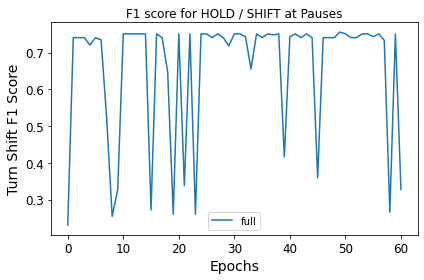

In [ ]:
# Visualize the F-1 Scores 

plt.plot(list(f1_scores.values()), label=FEATURE_SET)
plt.title("F1 score for HOLD / SHIFT at Pauses")
plt.xlabel("Epochs")
plt.ylabel("Turn Shift F1 Score")
plt.legend()
save_fig(REPORTS_DIR,"Exp-4.2-Figure-4-{}".format(FEATURE_SET)) 
plt.show()